Miguel Conner

# Decision Trees

We will follow the outline below. Essentially, I have explored the data and built features that help sepearate patients that have longer stays and patients that have shorter stays. Then, I created a few pipelines that take in the dataframe and do cross-validation on a number of parameters. Finally, we combine the optimal models using ensemble models to make models of our models.

1. Load Packages + Data
2. Data Exploration and Feature Engineering
3. Organize Dataset
4. Decision Tree
5. Random Forest
6. XGBoost
7. Neural Network
8. Voting Classifier
9. Superlearner

# 1. Load Packages + Data

In [2388]:
# import sys
# !{sys.executable} -m pip install xgboost

In [2389]:
#Load packages
%matplotlib inline
import matplotlib.pylab as plt

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import category_encoders
from math import floor, ceil
import random

## Load Data

In [2390]:
# Load the data
training = pd.read_csv('mimic_train.csv')
val = pd.read_csv('mimic_test_los.csv')

#Extra data
diag = pd.read_csv('MIMIC_metadata_diagnose.csv')
comorb = pd.read_csv('MIMIC_diagnoses.csv')
comorb['ICD9_CODE'] = comorb['ICD9_CODE'].astype(str)
#comorb['ICD9_CODE'] = [s.lstrip("0") for s in comorb['ICD9_CODE']]  
comorb['subject_id'] = comorb['SUBJECT_ID']

#Remove columns we can't use
training = training.drop(['DOD'], axis=1)
training = training.drop(['DISCHTIME'], axis=1)
training = training.drop(['DEATHTIME'], axis=1)
training = training.drop(['Diff'], axis=1)
training['MARITAL_STATUS'] = training['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)') #  <--- Some values are missing so combine NaN with already existing category

### Import death predictions from our knn/svm model

We will use our SVM classifier to predict the HOSPITAL_EXPIRE_FLAG column (instead of using the actual HOSPITAL_EXPIRE_FLAG column.)

In [2391]:
# Load the death predictions from our svm model
svm_deathpred = pd.read_csv('svm_deathpred.csv')
training = pd.merge(training, svm_deathpred, on='icustay_id', how='left') 
svm_deathpred_val = pd.read_csv('svm_deathpred_te.csv')
val = pd.merge(val, svm_deathpred_val, on='icustay_id', how='left') 

In [2392]:
X_tr = training
y_tr = training['LOS']
X_te = val

# This will give us an extra test set which we will use to train our super learner.
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, random_state=42, train_size = 0.9)

In [2393]:
# Now we can drop the hospital exprire flag since we have our predictions
X_tr = X_tr.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)

# We will combine a test set with the validation set so that they can both be fit (no leakage). 
# We will later separate them after the preprocessing.
X_te = pd.concat([X_te,val],ignore_index=True)
X_te = X_te.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)

In [2394]:
X_te

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS,pred_death,Diff
0,63519,170597,211145,54.0,82.0,68.766667,59.0,181.0,118.241379,43.0,91.0,63.137931,46.0,117.0,77.700000,10.0,20.0,14.433333,35.666667,36.888889,36.435185,81.0,100.0,96.266667,60.0,404.0,187.000000,M,2109-07-01 00:00:00,2182-04-24 08:00:00,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,ULCERATIVE COLITIS CHRONIC/SDA,5569,MICU,1.0214,0.008768,NaN
1,74795,102641,215021,62.0,96.0,83.484848,93.0,132.0,116.000000,43.0,72.0,56.323529,58.0,92.0,72.794118,13.0,28.0,20.857143,35.100000,37.900000,36.779630,91.0,100.0,97.121212,117.0,198.0,138.722222,M,2042-08-11 00:00:00,2105-01-14 07:30:00,ELECTIVE,Private,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT; ? ...,3950,CSRU,1.1635,0.000744,NaN
2,54587,102683,218147,55.0,77.0,63.555556,106.0,150.0,126.368421,55.0,118.0,75.789474,74.0,126.0,93.833333,8.0,22.0,15.047619,35.722222,36.722222,36.122222,94.0,100.0,98.722222,94.0,170.0,121.600000,F,2072-10-11 00:00:00,2124-04-10 18:24:00,EMERGENCY,Private,NOT SPECIFIED,SINGLE,WHITE,HEAD MASS,2252,SICU,0.7825,0.000918,NaN
3,19296,186066,231806,58.0,87.0,74.161290,104.0,159.0,131.793103,40.0,85.0,57.137931,54.0,93.0,74.517241,16.0,23.0,19.935484,35.055556,37.611111,36.527778,93.0,100.0,96.129032,151.0,253.0,203.000000,F,2080-11-20 00:00:00,2161-01-28 08:40:00,EMERGENCY,Medicare,OTHER,MARRIED,WHITE,CHOLANGITIS,0389,MICU,1.4138,0.005355,NaN
4,85539,179291,202318,86.0,116.0,108.066667,117.0,153.0,130.142857,75.0,100.0,86.857143,85.0,113.0,96.785714,11.0,21.0,14.466667,35.944444,37.000000,36.652778,93.0,100.0,96.400000,146.0,242.0,188.000000,F,2091-09-13 00:00:00,2147-12-08 19:43:00,EMERGENCY,Medicaid,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,CELLULITIS,27651,MICU,0.6169,0.000705,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7305,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,79.0,62.631579,66.0,89.0,75.588235,16.0,33.0,24.695652,35.555556,36.611111,36.244444,86.0,99.0,94.041667,160.0,323.0,234.000000,F,2085-07-03 00:00:00,2144-07-16 11:01:00,EMERGENCY,Medicare,OTHER,SINGLE,WHITE,MEDIASTINAL MASS,20152,SICU,NaN,0.011727,-49718.62088
7306,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,157.0,120.066667,M,2067-01-25 00:00:00,2143-03-28 10:45:00,ELECTIVE,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,4241,CSRU,NaN,0.321218,-49300.08263
7307,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,97.0,64.209302,66.0,115.0,83.860465,8.0,26.0,15.046512,36.611111,37.166667,36.914141,88.0,99.0,93.837209,112.0,220.0,164.555556,F,2020-12-16 00:00:00,2102-04-03 04:04:00,EMERGENCY,Medicare,GREEK ORTHODOX,WIDOWED,WHITE - RUSSIAN,SMALL BOWEL OBSTRUCTION;SEPSIS,34839,MICU,NaN,0.012475,-33708.91976
7308,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,74.0,55.702128,49.0,93.0,71.106383,8.0,23.0,17.560000,36.444444,36.500000,36.472222,93.0,100.0,98.022222,89.0,191.0,132.153846,M,2059-07-26 00:00:00,2138-05-19 07:15:00,ELECTIVE,Medicare,CATHOLIC,DIVORCED,WHITE,CORONARY ARTERY DISEASE\AORTIC VALVE / ASCENDI...,41401,CSRU,NaN,0.003031,-46198.14080


# 2. Data Exploration + Feature Engineering

We are going to come up with a bunch of different variables that will hopefully be useful in our model since we know that our model will filter out anything that is a bad predictor. For any categorical variables we create, we will try to look at the mean LOS for each category, and make sure they are quite different.

### Data Types and Histograms

In [2395]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18796 entries, 8704 to 15795
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      18796 non-null  int64  
 1   hadm_id         18796 non-null  int64  
 2   icustay_id      18796 non-null  int64  
 3   HeartRate_Min   16807 non-null  float64
 4   HeartRate_Max   16807 non-null  float64
 5   HeartRate_Mean  16807 non-null  float64
 6   SysBP_Min       16787 non-null  float64
 7   SysBP_Max       16787 non-null  float64
 8   SysBP_Mean      16787 non-null  float64
 9   DiasBP_Min      16786 non-null  float64
 10  DiasBP_Max      16786 non-null  float64
 11  DiasBP_Mean     16786 non-null  float64
 12  MeanBP_Min      16808 non-null  float64
 13  MeanBP_Max      16808 non-null  float64
 14  MeanBP_Mean     16808 non-null  float64
 15  RespRate_Min    16805 non-null  float64
 16  RespRate_Max    16805 non-null  float64
 17  RespRate_Mean   16805 non-nu

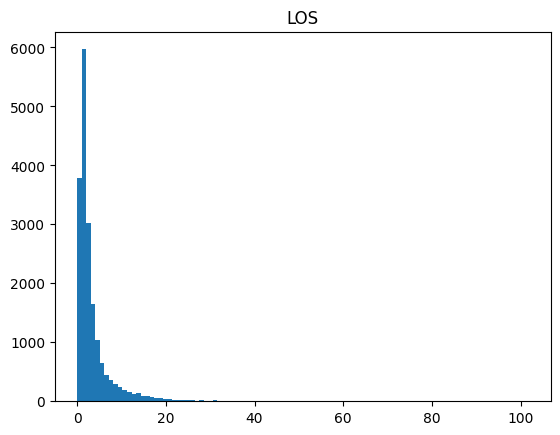

In [2396]:
# Take a look at how the LOS is distrbuted.
plt.hist(X_tr['LOS'], bins=100)
plt.title('LOS')
plt.show()

### Marital Status - clean data

In [2397]:
X_tr['MARITAL_STATUS'] = X_tr['MARITAL_STATUS'].astype(object) 
X_te['MARITAL_STATUS'] = X_te['MARITAL_STATUS'].astype(object) 

### Age

In [2398]:
# Calculate ages by removing gap. Set mysterious group of '>89' patients to desired value: 'over89value'
import datetime as dt
    
def age_calc_train(X, over89value):
    # format dates into standard
    df = X
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date
    df['date_of_admission'] = pd.to_datetime(df['ADMITTIME']).dt.date
    df['age'] = df.apply(lambda e: (e['date_of_admission'] - e['DOB']).days/365, axis=1)
    
    #find the edges of the "gap" between ages
    upper = []
    lower = []
    for age in df['age']:
        if age>100:
            upper.append(age)
        else:
            lower.append(age)
    u = min(upper)
    l = max(lower)
    diff = u-l
    
    cor_ages= [age-diff if age>150 else age for age in df['age']]
    df['cor_ages']=cor_ages
    
    # set special case of '>89' group (with made up birthdays) to specific value 
    mode = max(set(cor_ages), key=cor_ages.count)
    cor_ages= [over89value if age==mode else age for age in cor_ages]
    df['cor_ages']=cor_ages    
    df = df.drop(['DOB', 'date_of_admission', 'age'], axis=1)
    return df, diff

def age_calc_test(X_test, over89value, diff):
    df = X_test[['DOB', 'ADMITTIME']]
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date
    df['date_of_admission'] = pd.to_datetime(df['ADMITTIME']).dt.date
    df['age'] = df.apply(lambda e: (e['date_of_admission'] - e['DOB']).days/365, axis=1)
    cor_ages= [age-diff if age>150 else age for age in df['age']]
    mode = max(set(cor_ages), key=cor_ages.count)
    cor_ages= [over89value if age==mode else age for age in cor_ages]     #shift to zame age as above
    X_te['cor_ages']=cor_ages
    return X_te

In [2399]:
X_tr, dif = age_calc_train(X_tr, 92)
X_te = age_calc_test(X_te, 92, dif)

In [2400]:
X_tr['cor_ages'] = X_tr['cor_ages'].round(0)
X_te['cor_ages'] = X_te['cor_ages'].round(0)

In [2401]:
# Also make categorical bins for ages: young, middle aged, and old.

age_bins = []
for age in X_tr['cor_ages']:
    if age<21:
        age_bins.append('<21')
    elif age <41 and age>=21:
        age_bins.append('21 - 40')
    elif age <61 and age>=41:
        age_bins.append('41 - 60')
    elif age <81 and age>=61:
        age_bins.append('61 - 80')   
    elif age <91 and age>=81:
        age_bins.append('81 - 90')
    else:
        age_bins.append('91+')
X_tr['age_bins']=age_bins

age_bins = []
for age in X_te['cor_ages']:
    if age<21:
        age_bins.append('<21')
    elif age <41 and age>=21:
        age_bins.append('21 - 40')
    elif age <61 and age>=41:
        age_bins.append('41 - 60')
    elif age <81 and age>=61:
        age_bins.append('61 - 80')   
    elif age <91 and age>=81:
        age_bins.append('81 - 90')
    else:
        age_bins.append('91+')
X_te['age_bins']=age_bins

X_tr[['LOS', 'age_bins']].groupby(['age_bins']).mean()
#X_tr[['LOS', 'cor_ages']].groupby(['cor_ages']).mean()

,LOS
age_bins,
21 - 40,3.342896
41 - 60,3.722705
61 - 80,3.912716
81 - 90,3.720326
91+,2.857403
<21,2.502230


### Admission Hour

In [2402]:
# What infromation does admit time have? Really, the only relevant piece of info I could find is hour.

X_tr['admit_hour'] = pd.to_datetime(X_tr['ADMITTIME']).dt.hour
late_night =[]
for i in X_tr['admit_hour']:
    if i>= 19 or i<= 3:
        late_night.append('night')
    elif i<= 8 and i>= 5:
        late_night.append('morning')
    else:
        late_night.append('day')
X_tr['late_night'] =  late_night       

X_te['admit_hour'] = pd.to_datetime(X_te['ADMITTIME']).dt.hour
late_night =[]
for i in X_te['admit_hour']:
    if i>= 19 or i<= 3:
        late_night.append('night')
    elif i<= 8 and i>= 5:
        late_night.append('morning')
    else:
        late_night.append('day')
X_te['late_night'] =  late_night  

#Day
X_tr['admit_day'] = pd.to_datetime(X_tr['ADMITTIME']).dt.weekday
X_te['admit_day'] = pd.to_datetime(X_te['ADMITTIME']).dt.weekday

#Month
X_tr['admit_month'] = pd.to_datetime(X_tr['ADMITTIME']).dt.month
X_te['admit_month'] = pd.to_datetime(X_te['ADMITTIME']).dt.month

#Day of Year
X_tr['admit_dofy'] = pd.to_datetime(X_tr['ADMITTIME']).dt.dayofyear
X_te['admit_dofy'] = pd.to_datetime(X_te['ADMITTIME']).dt.dayofyear

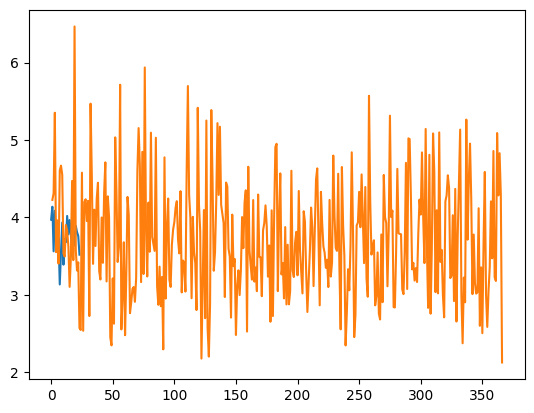

In [2403]:
a = X_tr[['LOS', 'admit_hour']].groupby(['admit_hour']).mean()
plt.plot(a['LOS'])

X_tr[['LOS', 'admit_day']].groupby(['admit_day']).mean()

X_tr[['LOS', 'admit_month']].groupby(['admit_month']).mean()

b= X_tr[['LOS', 'admit_dofy']].groupby(['admit_dofy']).mean()
plt.plot(b['LOS'])

In [2404]:
# Any holidays?
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-01-01', end='2014-12-31').to_pydatetime()
holidays = pd.to_datetime(holidays).date
holidays

array([datetime.date(2014, 1, 1), datetime.date(2014, 1, 20),
       datetime.date(2014, 2, 17), datetime.date(2014, 5, 26),
       datetime.date(2014, 7, 4), datetime.date(2014, 9, 1),
       datetime.date(2014, 10, 13), datetime.date(2014, 11, 11),
       datetime.date(2014, 11, 27), datetime.date(2014, 12, 25)],
      dtype=object)

In [2405]:
pd.to_datetime(X_tr['ADMITTIME']).dt.date

8704     2182-06-02
19824    2116-06-08
11330    2142-09-07
5474     2160-07-07
19155    2151-10-10
            ...    
11284    2112-07-12
11964    2133-03-27
5390     2169-10-01
860      2132-07-02
15795    2151-05-27
Name: ADMITTIME, Length: 18796, dtype: object

### Medical Data

In [2406]:
# # log Transform some skewed data
# from math import log
# to_trans = ['Glucose_Mean','Glucose_Max','Glucose_Min','TempC_Max', 
#             'SysBP_Mean', 'MeanBP_Mean', 'RespRate_Max','RespRate_Mean']
# for element in to_trans:
#     X_tr[element] = np.log10(X_tr[element])
#     X_te[element] = np.log10(X_te[element])

### Diagnosis: look for keywords associated with mortality

In [2407]:
one_std_LOS = X_tr['LOS'].mean()+ X_tr['LOS'].std()
half_std_LOS = X_tr['LOS'].mean()+ 0.5*X_tr['LOS'].std()
mean_LOS = X_tr['LOS'].mean()

In [2408]:
# # Look for words in 'DIAGNOSIS' column that are associated with death
# # NOTE: this takes a while to run so leave it commented out. 
# # It looks through ALL of the words or phrases in all of the columns

# import re

# res = [re.split(',|-|!|;|\?|\\\\|/', i) for i in X_tr['DIAGNOSIS']]
# res
# flat_list = [item for sublist in res for item in sublist]
# flat_list.append('S/P')
# len(flat_list)

# words = []
# for word in flat_list:
#     value = X_tr['LOS'][[word in x for x in X_tr['DIAGNOSIS']]].mean()
#     hits = sum([1 if word in x else 0 for x in X_tr['DIAGNOSIS']])
#     words.append([word, value, hits])


# # Look for words associated w greater than one standard deviation of the mean hostipal stay
# sorted_by_second = [tup for tup in words if tup[2] > 3 and tup[1] > one_std_LOS]
# sorted_by_second = [t for t in (set(tuple(i) for i in sorted_by_second))]
# sorted_by_second = sorted(sorted_by_second, key=lambda tup: -tup[1])
# sorted_by_second    

In [2409]:
# # These were the top words
# bad_words = [tuple[0] for tuple in sorted_by_second]
# bad_words.remove(' HEPATITIS')
# bad_words.remove(' AORTIC DISSECTION')
# bad_words.remove('GUN SHOT WOUND ') 
# bad_words.append('HEPATITIS')
# bad_words.append('AORTIC DISSECTION')
# bad_words.append('GUN SHOT WOUND') 
bad_words = ['HODGKINS',
 'ENTEROCUTANEOUS FISTULA',
 'OP KIDNEY',
 'HEPATICOCELLULAR CARCINOMA',
 'CHOLYCYSTITIS',
 'TRACHEOMALACIA',
 'ACUTE PANCREATITIS',
 'CORD INJURY',
 'SPINAL CORD INJURY',
 'ACUTE RESPIRATORY DISTRESS SYNDROME',
 'PERFORATED GASTRIC ULCER',
 'TYPE A DISSECTION',
 'P KIDNEY',
 'ABDOMINAL DISTENSION',
 'HEPATIC FAILURE',
 'ANKLE FRACTURE',
 'ENDOSCOPY',
 'ACUTE RESPIRATORY DISTRESS',
 'GASTRIC ULCER',
 'HEMORRHAGIC STROKE',
 'GUN SHOT WOUND',
 'ARDS',
 'POST OP INFECTION',
 'POLY TRAUMA',
 'BILIARY STRICTURE',
 'ETOH CIRRHOSIS',
 'BONE MARROW TRANSPLANT',
 'ATRIAL FIBRILATION',
 'SPINAL CORD COMPRESSION',
 'TRACHEOBRONCHIAL MALACIA',
 'O ENDOCARDITIS',
 'KNEE INFECTION',
 'FTT',
 'ACUTE RESPIRATORY FAILURE',
 'HEPATITIS',
 'AORTIC DISSECTION']

In [2410]:
pattern = '|'.join(bad_words)
pattern
X_tr['bad']=[1 if row else 0 for row in X_tr.DIAGNOSIS.str.contains(pattern)]
X_te['bad']=[1 if row else 0 for row in X_te.DIAGNOSIS.str.contains(pattern)]
X_tr[['LOS', 'bad']].groupby(['bad']).mean()

,LOS
bad,
0,3.633732
1,9.082995


### Cancer: look for words in Diagnosis column associated with 'cancer' and label them

In [2411]:
X_tr['LOS'][['CANCER' in str(x) or 'KEMIA' in str(x) or 'NOMA' in str(x) in x for x in X_tr['DIAGNOSIS']]].mean()
X_tr['cancer']=[1.0 if 'CANCER' in str(x) or 'KEMIA' in str(x) or 'NOMA' in str(x) else 0 for x in X_tr['DIAGNOSIS']]
X_te['cancer']=[1.0 if 'CANCER' in str(x) or 'KEMIA' in str(x) or 'NOMA' in str(x) else 0 for x in X_te['DIAGNOSIS']]
X_tr[['LOS', 'cancer']].groupby(['cancer']).mean()

,LOS
cancer,
0.0,3.706925
1.0,4.183544


### Count Comorbidities in Extra Dataset

In [2412]:
# COUNT NUMBER OF COMORBIDITIES
# Training set - count comorbidities
comorb_counts = comorb.groupby('subject_id')['ICD9_CODE'].nunique()
X_tr = pd.merge(X_tr, comorb_counts, on='subject_id', how='left')
X_tr['comorb']=X_tr['ICD9_CODE'].fillna(0).astype(np.float64)   
X_tr = X_tr.drop(['ICD9_CODE'], axis = 1)

# Test set - count comorbidities
comorb_counts = comorb.groupby('subject_id')['ICD9_CODE'].nunique()
X_te = pd.merge(X_te, comorb_counts, on='subject_id', how='left')
X_te['comorb']=X_te['ICD9_CODE'].fillna(0).astype(np.float64)
X_te = X_te.drop(['ICD9_CODE'],axis=1)

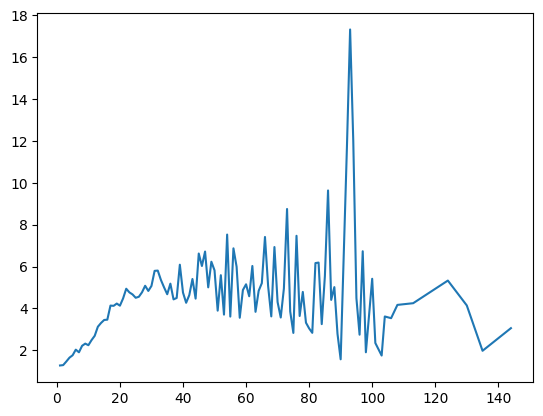

In [2413]:
c = X_tr[['LOS', 'comorb']].groupby(['comorb']).mean()
plt.plot(c['LOS'])

In [2414]:
X_tr['comorb_lots'] = [1 if i>= 9 else 0 for i in X_tr['comorb']]
X_tr['comorb_lots'] = X_tr['comorb_lots'].astype(np.float64)
X_te['comorb_lots'] = [1 if i>= 9 else 0 for i in X_te['comorb']]
X_te['comorb_lots'] = X_te['comorb_lots'].astype(np.float64)
X_tr[['LOS', 'comorb_lots']].groupby(['comorb_lots']).mean()

,LOS
comorb_lots,
0.0,1.897797
1.0,4.065860


### Count ICU Stays

In [2415]:
# Count stays by patient
subj_counts = X_tr.groupby('subject_id')['icustay_id'].nunique()
X_tr = pd.merge(X_tr, subj_counts, on='subject_id', how='left') 
subj_countse = X_te.groupby('subject_id')['icustay_id'].nunique()
X_te = pd.merge(X_te, subj_countse, on='subject_id', how='left') 

In [2416]:
X_te

,subject_id,hadm_id,icustay_id_x,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS,pred_death,Diff,cor_ages,age_bins,admit_hour,late_night,admit_day,admit_month,admit_dofy,bad,cancer,comorb,comorb_lots,icustay_id_y
0,63519,170597,211145,54.0,82.0,68.766667,59.0,181.0,118.241379,43.0,91.0,63.137931,46.0,117.0,77.700000,10.0,20.0,14.433333,35.666667,36.888889,36.435185,81.0,100.0,96.266667,60.0,404.0,187.000000,M,2109-07-01 00:00:00,2182-04-24 08:00:00,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,ULCERATIVE COLITIS CHRONIC/SDA,5569,MICU,1.0214,0.008768,NaN,73.0,61 - 80,8,morning,2,4,114,0,0.0,33.0,1.0,2
1,74795,102641,215021,62.0,96.0,83.484848,93.0,132.0,116.000000,43.0,72.0,56.323529,58.0,92.0,72.794118,13.0,28.0,20.857143,35.100000,37.900000,36.779630,91.0,100.0,97.121212,117.0,198.0,138.722222,M,2042-08-11 00:00:00,2105-01-14 07:30:00,ELECTIVE,Private,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT; ? ...,3950,CSRU,1.1635,0.000744,NaN,62.0,61 - 80,7,morning,2,1,14,0,0.0,12.0,1.0,1
2,54587,102683,218147,55.0,77.0,63.555556,106.0,150.0,126.368421,55.0,118.0,75.789474,74.0,126.0,93.833333,8.0,22.0,15.047619,35.722222,36.722222,36.122222,94.0,100.0,98.722222,94.0,170.0,121.600000,F,2072-10-11 00:00:00,2124-04-10 18:24:00,EMERGENCY,Private,NOT SPECIFIED,SINGLE,WHITE,HEAD MASS,2252,SICU,0.7825,0.000918,NaN,52.0,41 - 60,18,day,0,4,101,0,0.0,10.0,1.0,1
3,19296,186066,231806,58.0,87.0,74.161290,104.0,159.0,131.793103,40.0,85.0,57.137931,54.0,93.0,74.517241,16.0,23.0,19.935484,35.055556,37.611111,36.527778,93.0,100.0,96.129032,151.0,253.0,203.000000,F,2080-11-20 00:00:00,2161-01-28 08:40:00,EMERGENCY,Medicare,OTHER,MARRIED,WHITE,CHOLANGITIS,0389,MICU,1.4138,0.005355,NaN,80.0,61 - 80,8,morning,2,1,28,0,0.0,35.0,1.0,1
4,85539,179291,202318,86.0,116.0,108.066667,117.0,153.0,130.142857,75.0,100.0,86.857143,85.0,113.0,96.785714,11.0,21.0,14.466667,35.944444,37.000000,36.652778,93.0,100.0,96.400000,146.0,242.0,188.000000,F,2091-09-13 00:00:00,2147-12-08 19:43:00,EMERGENCY,Medicaid,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,CELLULITIS,27651,MICU,0.6169,0.000705,NaN,56.0,41 - 60,19,night,4,12,342,0,0.0,24.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7305,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,79.0,62.631579,66.0,89.0,75.588235,16.0,33.0,24.695652,35.555556,36.611111,36.244444,86.0,99.0,94.041667,160.0,323.0,234.000000,F,2085-07-03 00:00:00,2144-07-16 11:01:00,EMERGENCY,Medicare,OTHER,SINGLE,WHITE,MEDIASTINAL MASS,20152,SICU,NaN,0.011727,-49718.62088,59.0,41 - 60,11,day,3,7,198,0,0.0,87.0,1.0,3
7306,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,157.0,120.066667,M,2067-01-25 00:00:00,2143-03-28 10:45:00,ELECTIVE,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,4241,CSRU,NaN,0.321218,-49300.08263,76.0,61 - 80,10,day,3,3,87,0,0.0,20.0,1.0,1
7307,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,97.0,64.209302,66.0,115.0,83.860465,8.0,26.0,15.046512,36.611111,37.166667,36.914141,88.0,99.0,93.837209,112.0,220.0,164.555556,F,2020-12-16 00:00:00,2102-04-03 04:04:00,EMERGENCY,Medicare,GREEK ORTHODOX,WIDOWED,WHITE - RUSSIAN,SMALL BOWEL OBSTRUCTION;SEPSIS,34839,MICU,NaN,0.012475,-33708.91976,81.0,81 - 90,4,day,0,4,93,0,0.0,22.0,1.0,2
7308,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,74.0,55.702128,49.0,93.0,71.106383,8.0,23.0,17.560000,36.444

In [2417]:
X_tr = X_tr.rename(columns={"icustay_id_y": "icu_stays"})
X_te = X_te.rename(columns={"icustay_id_y": "icu_stays"})

In [2418]:
X_tr['multiple_icu']=[1.0 if x > 10 else 0 for x in X_tr['icu_stays']]
X_tr['multiple_icu'] = X_tr['multiple_icu'].astype(np.float64)
X_te['multiple_icu']=[1.0 if x > 10 else 0 for x in X_te['icu_stays']]
X_tr['multiple_icu'] =X_tr['multiple_icu'].astype(np.float64)
X_tr[['LOS', 'icu_stays']].groupby(['icu_stays']).mean()

,LOS
icu_stays,
1,3.514629
2,3.897085
3,4.424117
4,4.757360
5,3.747001
6,4.313744
7,4.639400
8,5.379559
9,5.884578


### Hospital Admissions

In [2419]:
# See if its a repeat admission
X_tr['hadm_count'] = X_tr.hadm_id.map(X_tr.hadm_id.value_counts()).astype(np.float64)
X_te['hadm_count'] = X_te.hadm_id.map(X_te.hadm_id.value_counts()).astype(np.float64)

In [2420]:
X_tr[['LOS', 'hadm_count']].groupby(['hadm_count']).mean().head(20)
X_tr['multiple_hadm']=[1.0 if x > 1 else 0 for x in X_tr['hadm_count']]
X_te['multiple_hadm']=[1.0 if x > 1 else 0 for x in X_te['hadm_count']]
X_tr[['LOS', 'multiple_hadm']].groupby(['multiple_hadm']).mean()

,LOS
multiple_hadm,
0.0,3.632648
1.0,4.529181


### Ethnicity - group high-risk ethnicities together in binary variable

In [2421]:
X_tr['highrisk_eth']=[1.0 if str(x)=='UNKNOWN/NOT SPECIFIED' or str(x)=='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' or str(x)=='UNABLE TO OBTAIN' or str(x)=='MULTI RACE ETHNICITY' or str(x) =='ASIAN - CAMBODIAN' or str(x)=='ASIAN - JAPANESE' or str(x)=='ASIAN - KOREAN' else 0 for x in X_tr['ETHNICITY']]
X_te['highrisk_eth']=[1.0 if str(x)=='UNKNOWN/NOT SPECIFIED' or str(x)=='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' or str(x)=='UNABLE TO OBTAIN' or str(x)=='MULTI RACE ETHNICITY' or str(x) =='ASIAN - CAMBODIAN' or str(x)=='ASIAN - JAPANESE' or str(x)=='ASIAN - KOREAN' else 0 for x in X_te['ETHNICITY']]
X_tr['highrisk_eth'] = X_tr['highrisk_eth'].astype(np.float64)
X_te['highrisk_eth'] = X_te['highrisk_eth'].astype(np.float64)
X_tr[['LOS', 'highrisk_eth']].groupby(['highrisk_eth']).mean()

,LOS
highrisk_eth,
0.0,3.674135
1.0,4.394302


### 'is_most_recent'

In [2422]:
# A column that gives a 1 if it is the patients most recent stay (sorted by date)
X_tr['addate'] = pd.to_datetime(X_tr['ADMITTIME']).dt.date
a = X_tr.sort_values('addate').groupby('subject_id').tail(1)
X_tr['is_most_recent'] = [1 if val in list(a['icustay_id_x']) else 0 for val in X_tr['icustay_id_x']]
X_tr = X_tr.drop(['addate'], axis=1)

In [2423]:
X_te['addate'] = pd.to_datetime(X_te['ADMITTIME']).dt.date
a = X_te.sort_values('addate').groupby('subject_id').tail(1)
X_te['is_most_recent'] = [1 if val in list(a['icustay_id_x']) else 0 for val in X_te['icustay_id_x']]
X_te = X_te.drop(['addate'], axis=1)

In [2424]:
X_tr[['LOS', 'is_most_recent']].groupby(['is_most_recent']).mean()

,LOS
is_most_recent,
0,4.313322
1,3.563687


### 'first_stay'

In [2425]:
# A column that gives a 1 if it is the patients first stay (sorted by date)
X_tr['addate'] = pd.to_datetime(X_tr['ADMITTIME']).dt.date
a = X_tr.sort_values('addate').groupby('subject_id').head(1)
X_tr['is_first'] = [1 if val in list(a['icustay_id_x']) else 0 for val in X_tr['icustay_id_x']]
X_tr = X_tr.drop(['addate'], axis=1)

In [2426]:
X_te['addate'] = pd.to_datetime(X_te['ADMITTIME']).dt.date
a = X_te.sort_values('addate').groupby('subject_id').head(1)
X_te['is_first'] = [1 if val in list(a['icustay_id_x']) else 0 for val in X_te['icustay_id_x']]
X_te = X_te.drop(['addate'], axis=1)

In [2427]:
X_tr[['LOS', 'is_first']].groupby(['is_first']).mean()

,LOS
is_first,
0,3.906750
1,3.667666


### Target Encode ICD9 Codes from Extra Dataset

In [2428]:
X_tr = pd.merge(X_tr,comorb[['subject_id', 'ICD9_CODE']],on='subject_id',how='left')
X_te = pd.merge(X_te,comorb[['subject_id', 'ICD9_CODE']],on='subject_id',how='left')

X_tr = pd.merge(X_tr,diag,on='ICD9_CODE',how='left')
X_te = pd.merge(X_te,diag,on='ICD9_CODE',how='left')

#target encode - testing with different smoothing values shows optimal values are the ones used
from category_encoders import TargetEncoder
targ_encoder = TargetEncoder(smoothing=2, min_samples_leaf=5) #smoothing=50, min_samples_leaf=100
X_tr['target_ICD9'] = targ_encoder.fit_transform(X_tr['ICD9_CODE'], X_tr['LOS'])
X_te['target_ICD9'] = targ_encoder.transform(X_te['ICD9_CODE'])


In [2429]:
X_tr['subcode'] = X_tr.ICD9_CODE.str.extract(r"([A-Z]+)")
X_tr['subcode'] = X_tr['subcode'].fillna('N')
for code in X_tr['ICD9_CODE']:
    if code.isdigit():
        c = code[:len(code)-2]
        code = c

In [2430]:
X_te['subcode'] = X_te.ICD9_CODE.str.extract(r"([A-Z]+)")
X_te['subcode'] = X_te['subcode'].fillna('N')
for code in X_te['ICD9_CODE']:
    if code.isdigit():
        c = code[:len(code)-2]
        code = c

In [2431]:
pd.set_option('display.max_columns', None)
X_tr.head(40)

,subject_id,hadm_id,icustay_id_x,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS,pred_death,cor_ages,age_bins,admit_hour,late_night,admit_day,admit_month,admit_dofy,bad,cancer,comorb,comorb_lots,icu_stays,multiple_icu,hadm_count,multiple_hadm,highrisk_eth,is_most_recent,is_first,ICD9_CODE,SHORT_DIAGNOSE,LONG_DIAGNOSE,target_ICD9,subcode
0,81679,170665,288878,80.0,131.0,97.764706,105.0,154.0,135.400000,43.0,105.0,68.920000,61.0,111.0,85.777778,18.0,32.0,26.545455,35.611111,37.444444,36.413580,86.0,100.0,95.941176,62.0,62.0,62.00,F,2182-06-02 08:04:00,EMERGENCY,Medicare,CATHOLIC,WIDOWED,MULTI RACE ETHNICITY,CHOLECYSTITIS,5761,MICU,1.3955,0.004131,92.0,91+,8,morning,6,6,153,0,0.0,6.0,0.0,1,0.0,1.0,0.0,1.0,1,1,5761,Cholangitis,Cholangitis,4.058016,N
1,81679,170665,288878,80.0,131.0,97.764706,105.0,154.0,135.400000,43.0,105.0,68.920000,61.0,111.0,85.777778,18.0,32.0,26.545455,35.611111,37.444444,36.413580,86.0,100.0,95.941176,62.0,62.0,62.00,F,2182-06-02 08:04:00,EMERGENCY,Medicare,CATHOLIC,WIDOWED,MULTI RACE ETHNICITY,CHOLECYSTITIS,5761,MICU,1.3955,0.004131,92.0,91+,8,morning,6,6,153,0,0.0,6.0,0.0,1,0.0,1.0,0.0,1.0,1,1,57441,Choledochlith/gb NEC-obs,Calculus of bile duct with other cholecystitis...,2.498542,N
2,81679,170665,288878,80.0,131.0,97.764706,105.0,154.0,135.400000,43.0,105.0,68.920000,61.0,111.0,85.777778,18.0,32.0,26.545455,35.611111,37.444444,36.413580,86.0,100.0,95.941176,62.0,62.0,62.00,F,2182-06-02 08:04:00,EMERGENCY,Medicare,CATHOLIC,WIDOWED,MULTI RACE ETHNICITY,CHOLECYSTITIS,5761,MICU,1.3955,0.004131,92.0,91+,8,morning,6,6,153,0,0.0,6.0,0.0,1,0.0,1.0,0.0,1.0,1,1,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",4.235836,N
3,81679,170665,288878,80.0,131.0,97.764706,105.0,154.0,135.400000,43.0,105.0,68.920000,61.0,111.0,85.777778,18.0,32.0,26.545455,35.611111,37.444444,36.413580,86.0,100.0,95.941176,62.0,62.0,62.00,F,2182-06-02 08:04:00,EMERGENCY,Medicare,CATHOLIC,WIDOWED,MULTI RACE ETHNICITY,CHOLECYSTITIS,5761,MICU,1.3955,0.004131,92.0,91+,8,morning,6,6,153,0,0.0,6.0,0.0,1,0.0,1.0,0.0,1.0,1,1,2948,Mental disor NEC oth dis,Other persistent mental disorders due to condi...,3.533521,N
4,81679,170665,288878,80.0,131.0,97.764706,105.0,154.0,135.400000,43.0,105.0,68.920000,61.0,111.0,85.777778,18.0,32.0,26.545455,35.611111,37.444444,36.413580,86.0,100.0,95.941176,62.0,62.0,62.00,F,2182-06-02 08:04:00,EMERGENCY,Medicare,CATHOLIC,WIDOWED,MULTI RACE ETHNICITY,CHOLECYSTITIS,5761,MICU,1.3955,0.004131,92.0,91+,8,morning,6,6,153,0,0.0,6.0,0.0,1,0.0,1.0,0.0,1.0,1,1,496,Chr airway obstruct NEC,"Chronic airway obstruction, not elsewhere clas...",4.096849,N
5,81679,170665,288878,80.0,131.0,97.764706,105.0,154.0,135.400000,43.0,105.0,68.920000,61.0,111.0,85.777778,18.0,32.0,26.545455,35.611111,37.444444,36.413580,86.0,100.0,95.941176,62.0,62.0,62.00,F,2182-06-02 08:04:00,EMERGENCY,Medicare,CATHOLIC,WIDOWED,MULTI RACE ETHNICITY,CHOLECYSTITIS,5761,MICU,1.3955,0.004131,92.0,91+,8,morning,6,6,153,0,0.0,6.0,0.0,1,0.0,1.0,0.0,1.0,1,1,4019,Hypertension NOS,Unspecified essential hypertension,3.791375,N
6,72670,189049,289816,92.0,114.0,103.743590,76.0,159.0,125.750000,55.0,118.0,73.031250,62.0,126.0,84.634146,17.0,42.0,27.673469,36.000000,37.111111,36.542735,76.0,100.0,96.128205,178.0,330.0,260.00,M,2116-06-08 09:39:00,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,NON-HODGKIN LYMPHOMA,20200,MICU,32.9545,0.968828,64.0,61 - 80,9,day,0,6,160,0,0.0,22.0,1.0,2,0.0,2.0,1.0,0.0,1,0,20200,Ndlr lym unsp xtrndl org,"Nodular lymphoma, unspecified site, extranodal...",15.390432,N
7,72670,189049,289816,92.0,114.0,103.743590,76.0,159.0,125.750000,55.0,118.0,73.031250,62.0,126.0,84.634146,17.0,42.0,27

In [2432]:
# Some duplicate values we need to get rid of
X_tr = X_tr.drop_duplicates()
X_te = X_te.drop_duplicates()

In [2433]:
X_tr['shortcodes'] = X_tr['ICD9_CODE'].apply(lambda x: x[:len(x)-2] if x.isdigit() else '-1') 
X_tr['shortcodes'] = X_tr['shortcodes'].apply(lambda x: 0 if x=='' else x) 
X_tr['shortcodes'] = X_tr['shortcodes'].astype(str).astype(int)

X_tr.loc[(X_tr['shortcodes'] >= 0) & (X_tr['shortcodes'] <= 139), 'subcode'] = 'Infectious and Parasitic Diseases'
X_tr.loc[(X_tr['shortcodes'] >= 140) & (X_tr['shortcodes'] <= 239), 'subcode'] = 'Neoplasms'
X_tr.loc[(X_tr['shortcodes'] >= 240) & (X_tr['shortcodes'] <= 279), 'subcode'] = 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
X_tr.loc[(X_tr['shortcodes'] >= 280) & (X_tr['shortcodes'] <= 289), 'subcode'] = 'Diseases of the Blood and Blood-forming Organs'
X_tr.loc[(X_tr['shortcodes'] >= 290) & (X_tr['shortcodes'] <= 319), 'subcode'] = 'Mental Disorders'
X_tr.loc[(X_tr['shortcodes'] >= 320) & (X_tr['shortcodes'] <= 389), 'subcode'] = 'Diseases of the Nervous System and Sense Organs'
X_tr.loc[(X_tr['shortcodes'] >= 390) & (X_tr['shortcodes'] <= 459), 'subcode'] = 'Diseases of the Circulatory System'
X_tr.loc[(X_tr['shortcodes'] >= 460) & (X_tr['shortcodes'] <= 519), 'subcode'] = 'Diseases of the Respiratory System'
X_tr.loc[(X_tr['shortcodes'] >= 520) & (X_tr['shortcodes'] <= 579), 'subcode'] = 'Diseases of the Digestive System'
X_tr.loc[(X_tr['shortcodes'] >= 580) & (X_tr['shortcodes'] <= 629), 'subcode'] = 'Diseases of the Genitourinary System'
X_tr.loc[(X_tr['shortcodes'] >= 630) & (X_tr['shortcodes'] <= 679), 'subcode'] = 'Complications of Pregnancy, Childbirth, and the Puerperium'
X_tr.loc[(X_tr['shortcodes'] >= 680) & (X_tr['shortcodes'] <= 709), 'subcode'] = 'Diseases of the Skin and Subcutaneous Tissue'
X_tr.loc[(X_tr['shortcodes'] >= 710) & (X_tr['shortcodes'] <= 739), 'subcode'] = 'Diseases of the Musculoskeletal System and Connective Tissue'
X_tr.loc[(X_tr['shortcodes'] >= 740) & (X_tr['shortcodes'] <= 759), 'subcode'] = 'Congenital Anomalies'
X_tr.loc[(X_tr['shortcodes'] >= 760) & (X_tr['shortcodes'] <= 779), 'subcode'] = 'Certain Conditions originating in the Perinatal Period'
X_tr.loc[(X_tr['shortcodes'] >= 780) & (X_tr['shortcodes'] <= 799), 'subcode'] = 'Symptoms, Signs and Ill-defined Conditions'
X_tr.loc[(X_tr['shortcodes'] >= 800) & (X_tr['shortcodes'] <= 999), 'subcode'] = 'Injury and Poisoning'
X_tr.loc[(X_tr['subcode'] == 'E'), 'subcode'] = 'Supplementary Classification of External Causes of Injury and Poisoning'
X_tr.loc[(X_tr['subcode'] == 'V'), 'subcode'] = 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'

In [2434]:
X_te['shortcodes'] = X_te['ICD9_CODE'].apply(lambda x: x[:len(x)-2] if x.isdigit() else '-1') 
X_te['shortcodes'] = X_te['shortcodes'].apply(lambda x: 0 if x=='' else x) 
X_te['shortcodes'] = X_te['shortcodes'].astype(str).astype(int)

X_te.loc[(X_te['shortcodes'] >= 0) & (X_te['shortcodes'] <= 139), 'subcode'] = 'Infectious and Parasitic Diseases'
X_te.loc[(X_te['shortcodes'] >= 140) & (X_te['shortcodes'] <= 239), 'subcode'] = 'Neoplasms'
X_te.loc[(X_te['shortcodes'] >= 240) & (X_te['shortcodes'] <= 279), 'subcode'] = 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
X_te.loc[(X_te['shortcodes'] >= 280) & (X_te['shortcodes'] <= 289), 'subcode'] = 'Diseases of the Blood and Blood-forming Organs'
X_te.loc[(X_te['shortcodes'] >= 290) & (X_te['shortcodes'] <= 319), 'subcode'] = 'Mental Disorders'
X_te.loc[(X_te['shortcodes'] >= 320) & (X_te['shortcodes'] <= 389), 'subcode'] = 'Diseases of the Nervous System and Sense Organs'
X_te.loc[(X_te['shortcodes'] >= 390) & (X_te['shortcodes'] <= 459), 'subcode'] = 'Diseases of the Circulatory System'
X_te.loc[(X_te['shortcodes'] >= 460) & (X_te['shortcodes'] <= 519), 'subcode'] = 'Diseases of the Respiratory System'
X_te.loc[(X_te['shortcodes'] >= 520) & (X_te['shortcodes'] <= 579), 'subcode'] = 'Diseases of the Digestive System'
X_te.loc[(X_te['shortcodes'] >= 580) & (X_te['shortcodes'] <= 629), 'subcode'] = 'Diseases of the Genitourinary System'
X_te.loc[(X_te['shortcodes'] >= 630) & (X_te['shortcodes'] <= 679), 'subcode'] = 'Complications of Pregnancy, Childbirth, and the Puerperium'
X_te.loc[(X_te['shortcodes'] >= 680) & (X_te['shortcodes'] <= 709), 'subcode'] = 'Diseases of the Skin and Subcutaneous Tissue'
X_te.loc[(X_te['shortcodes'] >= 710) & (X_te['shortcodes'] <= 739), 'subcode'] = 'Diseases of the Musculoskeletal System and Connective Tissue'
X_te.loc[(X_te['shortcodes'] >= 740) & (X_te['shortcodes'] <= 759), 'subcode'] = 'Congenital Anomalies'
X_te.loc[(X_te['shortcodes'] >= 760) & (X_te['shortcodes'] <= 779), 'subcode'] = 'Certain Conditions originating in the Perinatal Period'
X_te.loc[(X_te['shortcodes'] >= 780) & (X_te['shortcodes'] <= 799), 'subcode'] = 'Symptoms, Signs and Ill-defined Conditions'
X_te.loc[(X_te['shortcodes'] >= 800) & (X_te['shortcodes'] <= 999), 'subcode'] = 'Injury and Poisoning'
X_te.loc[(X_te['subcode'] == 'E'), 'subcode'] = 'Supplementary Classification of External Causes of Injury and Poisoning'
X_te.loc[(X_te['subcode'] == 'V'), 'subcode'] = 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'

In [2435]:
targ_encoder = TargetEncoder(smoothing=10, min_samples_leaf=10)
X_tr['ICD9_target_cat']  = targ_encoder.fit_transform(X_tr['subcode'], X_tr['LOS'])
X_te['ICD9_target_cat']  = targ_encoder.transform(X_te['subcode'])

X_tr['LONG_DIAGNOSE'] = X_tr['LONG_DIAGNOSE'].astype(object)

In [2436]:
# Redefine shortcodes to include V and E categories
X_tr['shortcodes'] = X_tr['ICD9_CODE'].apply(lambda x: x[:len(x)-2])
X_tr['shortcodes'] = X_tr['ICD9_CODE'].apply(lambda x: x[:len(x)-2])

In [2437]:
X_tr['shortcodes'] = X_tr['shortcodes'].astype(object)
X_te['shortcodes'] = X_te['shortcodes'].astype(object)

targ_encoder = TargetEncoder(smoothing=2, min_samples_leaf=5)
X_tr['shortcodes_target']  = targ_encoder.fit_transform(X_tr['shortcodes'], X_tr['LOS'])
X_te['shortcodes_target']  = targ_encoder.transform(X_te['shortcodes'])

In [2438]:
class AttributesAdder():
    def transform(self, X):
        X['max_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform(max).astype(np.float64)   
        X['mean_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform('mean').astype(np.float64)   
        X['min_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform(min).astype(np.float64)   
        X['med_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform('median').astype(np.float64) 
        #X['std_ICD9_target'] = X.groupby(['subject_id'])['target_ICD9'].transform('std').astype(np.float64)
        X['bad'] = X.groupby(['subject_id'])['bad'].transform('max').astype(np.float64)
        #X['max_ICD9_target_cat'] = X.groupby(['subject_id'])['target_ICD9'].transform(max).astype(np.float64)   
        X['mean_ICD9_target_cat'] = X.groupby(['subject_id'])['ICD9_target_cat'].transform('mean').astype(np.float64)
        X['mean_shortcodes_target'] = X.groupby(['subject_id'])['shortcodes_target'].transform('mean').astype(np.float64)

class AttributesRemover():
    def transform(self, X):
        cols = list(X.columns)
        cols.remove('ICD9_CODE')
        cols.remove('target_ICD9')
        cols.remove('subcode')
        cols.remove('ICD9_target_cat')
        cols.remove('shortcodes')
        cols.remove('shortcodes_target')
        cols.remove('LONG_DIAGNOSE')
        cols.remove('SHORT_DIAGNOSE')
        X = X[cols]
        
        X = X.drop_duplicates(keep="first", inplace=False)
        X = X.reset_index() 
        return X

In [2439]:
obj1 = AttributesAdder()
obj2 = AttributesRemover()
obj1.transform(X_tr)
obj1.transform(X_te)

In [2440]:
X_tr =obj2.transform(X_tr)
X_te =obj2.transform(X_te)

### 'all' and 'mtsq' - other relevant variables

In [2441]:
# Make a new variable that is the square of the mean of the target encoded comorbidities
X_tr['mtsq'] = [val*val for val in X_tr['mean_ICD9_target']]
X_te['mtsq'] = [val*val for val in X_te['mean_ICD9_target']]

# Create that is the sum of all the target variables.
X_tr['all'] = X_tr['comorb']*X_tr['mean_ICD9_target']
X_te['all'] = X_te['comorb']*X_te['mean_ICD9_target']

### Forward Fill and Backward Fill missing data

Initially I included a forward/backward fill imputer of missing data but it didn't work as well as just imputing the mean. (We justify this below in part 5.)

In [2442]:
X_tr.isnull().sum()
# X_tr = X_tr.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())
# X_te = X_te.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())
# X_tr = X_tr.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
# X_te = X_te.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
# X_tr.isnull().sum()

index                        0
subject_id                   0
hadm_id                      0
icustay_id_x                 0
HeartRate_Min             1989
                          ... 
med_ICD9_target              0
mean_ICD9_target_cat         0
mean_shortcodes_target       0
mtsq                         0
all                          0
Length: 66, dtype: int64

# 3. Organize Dataset

Organize the dataset before we plug it into our model. One pair of test/training data will be used for our pipelines, and uses all the training data. The other test/train pair contains some training data inside the testing data. This will be used to train our super learner. 

Finally, this step will help us in our pipeline to siphon off different columns to be processed differently.

In [2443]:
# specifcy reorder
training_order = training['icustay_id']
val_order = val['icustay_id']
both_order = val_order.append(training_order)

# And a special test set for our superlearner
X_trs = X_tr.iloc[X_tr['icustay_id_x'].map({v: k for k, v in enumerate(training_order)}).argsort()]
y_trs = y_tr
X_tes = X_te.iloc[X_te['icustay_id_x'].map({v: k for k, v in enumerate(both_order)}).argsort()]
y_tes = y_te

In [2444]:
X_trs = X_trs.reset_index(drop=True)
X_tes = X_tes.reset_index(drop=True)
y_trs = y_trs.reset_index(drop=True)
y_tes = y_tes.reset_index(drop=True)

In [2445]:
# Recombine datasets for regular pipeline tests (and reorder to match original data)
w = pd.concat([X_tr, X_te[~X_te['icustay_id_x'].isin(val['icustay_id'])]],ignore_index=True)
X_tr = w.iloc[w['icustay_id_x'].map({v: k for k, v in enumerate(training_order)}).argsort()]

v = X_te[X_te['icustay_id_x'].isin(val['icustay_id'])]
X_te = v.iloc[v['icustay_id_x'].map({v: k for k, v in enumerate(val_order)}).argsort()]

# Just to make sure things line up.
y_te = []
y_tr = training['LOS']

In [2446]:
X_tr = X_tr.reset_index(drop=True)
X_te = X_te.reset_index(drop=True)

In [2447]:
# Group all the columns that we need to we will target encode.
to_encode = list(X_tr.select_dtypes('object').columns)

# Group all columns that don't need to be target encoded
col = list(X_tr.select_dtypes('float64').columns) + list(X_tr.select_dtypes('int64').columns)
col.remove('index')
col.remove('subject_id')
col.remove('hadm_id')
col.remove('icustay_id_x')
col.remove('LOS')
col.remove('Diff')

# Group these two columns which we will target encode seperately with different parameters.
diff_te =['DIAGNOSIS', 'ICD9_diagnosis']
to_encode.remove('ICD9_diagnosis') 
to_encode.remove('DIAGNOSIS') 
to_encode.remove('DOB')
to_encode.remove('ADMITTIME')

# Pick the columns from the three groups.
X_tr = X_tr[col+to_encode+diff_te]
X_te = X_te[col+to_encode+diff_te]

In [2448]:
X_trs = X_trs[col+to_encode+diff_te]
X_tes = X_tes[col+to_encode+diff_te]

# 4. Decision Tree Pipeline

This Decision Tree pipeline (and the following pipelines in the notebook) will take in the dataframe we have at this point and:

1. do preprocessing (target encoding, scaling, imputing),
2. fit the model,
3. gridsearch to find the best hyper parameters for the model.

In [2350]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('target encoder icd9', TargetEncoder(smoothing=0, min_samples_leaf=5 ), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=10, min_samples_leaf=50), to_encode) 
    ], remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocess', preprocessor),
                    ('impute', SimpleImputer()), 
                    ('scale', StandardScaler()),
                    ('clf', DecisionTreeRegressor(criterion='squared_error'))
                  ])

In [2351]:
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target encoder icd9',
                                                  TargetEncoder(min_samples_leaf=5,
                                                                smoothing=0),
                                                  ['DIAGNOSIS',
                                                   'ICD9_diagnosis']),
                                                 ('target encoder',
                                                  TargetEncoder(min_samples_leaf=50,
                                                                smoothing=10),
                                                  ['GENDER', 'ADMISSION_TYPE',
                                                   'INSURANCE', 'RELIGION',
                                                   'MARITAL_STATUS',
                                                   'ETHNICITY',
                                                   'FIRST_CAREUNIT', 'age_bins',
                                                   'late_night'])])),
                ('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('clf', DecisionTreeRegressor())])

In [2352]:
def fit_and_print(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
    # define the parameter grid    
    param_grid = {
        'impute__strategy':['mean'],
        'clf__max_depth': [3, 5], 
        'clf__min_samples_split': [3,5],
        'clf__min_samples_leaf': [40, 50, 60],
        'clf__min_impurity_decrease': [0.0, 0.001],
    }
    
    # Notes on different parameters:
        # max_depth: Number of levels in a tree
        # min_samples_split: Minimum number of samples left to try a new split
        # min_samples_leaf: Minimum number of samples allowed in a leaf
        # min_impurity_decrease: Don't accept the split if we don't reach a minimum decrease in impurity
        # min_impurity_split: Early stop criteria, don't spl
    
    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'neg_root_mean_squared_error',
        param_grid=param_grid,
        cv=KFold(n_splits=10),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        'param_impute__strategy':'imp',
        'param_clf__max_depth': 'md',
        'param_clf__min_samples_split': 'mss',
        'param_clf__min_samples_leaf': 'msl',
        'param_clf__min_impurity_decrease': 'mid',
        'mean_test_score': 'RMSE:'})
    res = res[['RMSE:', 
                'md',
               'mss',
               'msl',
               'mid',
              ]].sort_values('RMSE:', ascending=False)
    print(res)
    return clf

In [2353]:
best_model = fit_and_print(pipeline, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

       RMSE: md mss msl    mid
17 -4.399573  5   5  60    0.0
16 -4.399573  5   3  60    0.0
23 -4.399606  5   5  60  0.001
22 -4.399606  5   3  60  0.001
15 -4.404721  5   5  50    0.0
14 -4.404721  5   3  50    0.0
21 -4.404754  5   5  50  0.001
20 -4.404754  5   3  50  0.001
13 -4.412411  5   5  40    0.0
12 -4.412411  5   3  40    0.0
18 -4.412444  5   3  40  0.001
19 -4.412444  5   5  40  0.001
7  -4.458800  3   5  40  0.001
6  -4.458800  3   3  40  0.001
10 -4.458800  3   3  60  0.001
11 -4.458800  3   5  60  0.001
1  -4.458800  3   5  40    0.0
9  -4.458800  3   5  50  0.001
8  -4.458800  3   3  50  0.001
5  -4.458800  3   5  60    0.0
4  -4.458800  3   3  60    0.0
3  -4.458800  3   5  50    0.0
2  -4.458800  3   3  50    0.0
0  -4.458800  3   3  40    0.0


In [ ]:
# predict
a = best_model.predict(X_te)

In [ ]:
# For computing out-of-sample RMSE score if test/train split was done at the beginning.
from sklearn import metrics
y_pred = np.array(a)
rmse = metrics.mean_squared_error(y_te, y_pred, squared=False)
-round(rmse,3)

In [ ]:
# Export data
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": a})

outputv.to_csv('output_dt_pred.csv', index=False)

This model works pretty well, we get an out of sample RMSE of about 4.5. We will improve upon this by trying a Random Forest model, which uses a bunch of extremely simple decision trees make our predictions. 

# 5. Random Forest Pipeline

Our Random Forest pipeline will look similar to the DT pipeline above. Here we have more hyperparameters to tune so we will play around with many of the parameters to find the optimal "range" of each hyperparameter.

Here, we will also gridsearch across our Target Encoding smoothing and min_samples_leaf values. This will help us squeeze out every bit of information from our dataset.

One of the really nice things about RF compared to some of our other more complicated models (e.g. Neural Networks) is that we can look at how important each feature is. We will comment this at the end.

In [2449]:
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('target encoder icd9', TargetEncoder(#smoothing=0, min_samples_leaf=5
                                             ), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(#smoothing=10, min_samples_leaf=100
                                        ), to_encode) 
    ], remainder='passthrough'
)

pipelinerf = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()), 
                    ('impute', SimpleImputer()), #tried KNNImputer but simple imputer actually works better
                    ('clf', RandomForestRegressor(criterion='squared_error',
                                                 bootstrap=True))
                  ])

pipelinerf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target encoder icd9',
                                                  TargetEncoder(),
                                                  ['DIAGNOSIS',
                                                   'ICD9_diagnosis']),
                                                 ('target encoder',
                                                  TargetEncoder(),
                                                  ['GENDER', 'ADMISSION_TYPE',
                                                   'INSURANCE', 'RELIGION',
                                                   'MARITAL_STATUS',
                                                   'ETHNICITY',
                                                   'FIRST_CAREUNIT', 'age_bins',
                                                   'late_night'])])),
                ('scale', StandardScaler()), ('impute', SimpleImputer()),
                ('clf', RandomForestRegressor())])

In [2450]:
def fit_and_print_rf(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
    # define the parameter grid    
    param_grid = {
        'preprocess__target encoder icd9__smoothing':[0],
        'preprocess__target encoder icd9__min_samples_leaf':[5],
        'preprocess__target encoder__smoothing':[10],
        'preprocess__target encoder__min_samples_leaf':[100],
        
        'impute__strategy':['mean'],
        
        'clf__n_estimators':[75, 150],
        'clf__max_features':[6],  #6 better than 4
        'clf__max_depth': [20],  #20 a bit better than 15
        'clf__min_samples_split': [3], #3 a bit better than 4
        'clf__min_samples_leaf': [4],  #4 a littel better than 3
        'clf__min_impurity_decrease': [0.0], #0 better than 0.05
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'neg_root_mean_squared_error',
        param_grid=param_grid,
        cv=KFold(n_splits=40),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        'param_preprocess__target encoder icd9__min_samples_leaf':'tei_mls',
        'param_preprocess__target encoder icd9__smoothing': 'tei_smoo',
        'param_preprocess__target encoder__min_samples_leaf':'te_mls',
        'param_preprocess__target encoder__smoothing': 'te_smoo',
        'param_impute__strategy':'imp',
        'param_clf__n_estimators':'n_est',
        'param_clf__max_features':'mf',
        'param_clf__max_depth': 'md',
        'param_clf__min_samples_split': 'mss',
        'param_clf__min_samples_leaf': 'msl',
        'param_clf__min_impurity_decrease': 'mid',
        'mean_test_score': 'RMSE:'})
    res = res[['RMSE:', 
               'imp',
               'n_est',
                'md',
               'mss',
               'msl',
               'mid',
               'mf',
               'te_smoo',
               'te_mls',
               'tei_smoo',
               'tei_mls'
              ]].sort_values('RMSE:', ascending=False)
    print(res)
    return clf

In [2451]:
# Tried many more values but settled on these parameters (see notes above)
rf_best_model = fit_and_print_rf(pipelinerf, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

      RMSE:   imp n_est  md mss msl  mid mf te_smoo te_mls tei_smoo tei_mls
1 -4.182765  mean   150  20   3   4  0.0  6      10    100        0       5
0 -4.205498  mean    75  20   3   4  0.0  6      10    100        0       5


#### Notes regarding imputing:
For the same parameters, I tested various combinations of imputation but the best combination was:

* simple mean imputer.

This works better than knn imputer and/or front/back fill so we have left the simple mean imputer in our final model in the pipeline above. (See the notes below).

In [457]:
# w regular mean imputer
#       RMSE: n_est  md mss msl  mid mf
# 6 -4.162136   100  20   3   3  0.0  6
# test set: -4.284

# again w no front fill and simple imputer
#       RMSE:   imp n_est  md mss msl  mid mf
# 0 -4.174412  mean   100  20   3   3  0.0  6
# test: -4.294

# w knn imputer
#       RMSE: n_neigh n_est  md mss msl  mid mf
# 1 -4.170423     100   100  20   3   3  0.0  6
#       RMSE: n_neigh n_est  md mss msl  mid mf
# 1 -4.184944     100   100  20   3   3  0.0  6
# test: -4.302, -4.299

# w front fill and back fill and knn imputer
#       RMSE: n_neigh n_est  md mss msl  mid mf
# 0 -4.182847     100   100  20   3   3  0.0  6
# test: -4.3

# w front fill and back fill and simple imputer
#       RMSE:   imp n_est  md mss msl  mid mf
# 0 -4.174585  mean   100  20   3   3  0.0  6
# test: -4.304

In [659]:
# Get our RF predictions.
a_rf = rf_best_model.predict(X_te)

In [660]:
# For computing out-of-sample RMSE score if test/train split was done at the beginning.
from sklearn import metrics
y_pred = np.array(a_rf)
rmse = metrics.mean_squared_error(y_te, y_pred, squared=False)
-round(rmse,3)

-4.261

In [ ]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": a_rf})

outputv.to_csv('output_rf_pred.csv', index=False)

#### * Random Forest is the best single model. *

### Feature Importance

The code below will give us our top 10 most important and top 10 least important features. These will slightly change everytime we run the model, but the same features should continute to come up with approximately the same values. Some variables we created of note:

* is_most_recent (whether or not its the most recent stay),
* icu_stays (the number of icu stays),
* mtsq (a variable that keeps track of the target encoded ICD9 codes),
* min_ICD9_target (another variable that keeps track of the target encoded ICD9 codes),
* is_first (whether or not its the patients first stay).


In [661]:
feature_names = [name for name in X_tr.columns]
feat_imp =  
len(feat_imp)
feat_importance = pd.DataFrame(feat_imp, feature_names)
feat_importance = feat_importance.apply(lambda x: round(x,4))
feat_importance.sort_values(by=[0], ascending=False).head(10)

,0
is_most_recent,0.1058
INSURANCE,0.1029
icu_stays,0.0762
GENDER,0.0701
RELIGION,0.0436
ADMISSION_TYPE,0.0409
HeartRate_Max,0.0338
mtsq,0.0298
is_first,0.0244
min_ICD9_target,0.0243


In [662]:
feat_importance.sort_values(by=[0], ascending=True).head(10)

,0
admit_hour,0.0000
mean_shortcodes_target,0.0001
admit_dofy,0.0006
admit_day,0.0013
admit_month,0.0013
SysBP_Max,0.0014
DIAGNOSIS,0.0022
HeartRate_Mean,0.0022
hadm_count,0.0023
SysBP_Mean,0.0024


Looks like many of the time-based variables we created (that aren't categorical), like day of year, admission hour, and admission month were not valued by our model. 

# 6. Xgboost

Xgboost is an extremely powerful model that can be a bit prone to overfitting, so we will need to take care when tuning our hyperparameters and do grid searches over many different hyperparameters. We will start by using values that roughly make sense (within expected ranges and tuned to avoid overfitting), and then narrowing down. I left some comments in the code that narrow down the range of many of the values. 

In [673]:
import xgboost as xgb

preprocessor = ColumnTransformer(
    transformers=[
        
        ('target encoder icd9', TargetEncoder(), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(), to_encode) 
    ], remainder='passthrough'
)

pipeline_xg = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer()),
                    ('clf', xgb.XGBRegressor(objective='reg:squarederror'
                                            ))
                  ])

pipeline_xg

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target encoder icd9',
                                                  TargetEncoder(),
                                                  ['DIAGNOSIS',
                                                   'ICD9_diagnosis']),
                                                 ('target encoder',
                                                  TargetEncoder(),
                                                  ['GENDER', 'ADMITTIME',
                                                   'ADMISSION_TYPE',
                                                   'INSURANCE', 'RELIGION',
                                                   'MARITAL_STATUS',
                                                   'ETHNICITY',
                                                   'FIRST_CAREUNIT', 'age_bins',
                                                   'late_night'])])),
                ('scale', StandardScaler()...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [687]:
def fit_and_print_xg(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
    # define the parameter grid    
    param_grid = {
        'preprocess__target encoder icd9__smoothing':[0],
        'preprocess__target encoder icd9__min_samples_leaf':[5],
        'preprocess__target encoder__smoothing':[10],
        'preprocess__target encoder__min_samples_leaf':[100],
        
        'impute__strategy':['mean'], # this was better than median or mode.
        
        'clf__n_estimators':[75, 100],  # 75 > 100 > 300
        'clf__max_depth': [5],  # for overfitting, 5 is better than 3 and 7 ,usually3-10 
        'clf__gamma':[0.01, 0.05, .1], # Gamma specifies the minimum loss reduction required for a split to occur.
                                # Makes the algorithm conservative. 
                                # The values can vary depending on the loss function and should be tuned. 
                                # Can be used to control overfitting. # 0 better than 0.01 slightly better than 0
        'clf__colsample_bytree':[1.0],   #1.0 better than 0.9 and 1.1
        'clf__learning_rate':[0.1], # typical:  0.01-0.2      # 0.1 >>> .225 and 0.01 > 0.075, 0.15
        'clf__min_child_weight':[12], #for overfitting       # 12 > 9 > 7,8,10?
        'clf__subsample':[1],   #1 better than .9
        'clf__reg_alpha':[0], #for regularization    #0 better than 0.05
        'clf__reg_lambda':[.8],  #regularize     #.8 better than .7 and .9
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'neg_root_mean_squared_error',
        param_grid=param_grid,
        cv=KFold(n_splits=20),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        'param_preprocess__target encoder icd9__min_samples_leaf':'tei_mls',
        'param_preprocess__target encoder icd9__smoothing': 'tei_smoo',
        'param_preprocess__target encoder__min_samples_leaf':'te_mls', 
        'param_preprocess__target encoder__smoothing': 'te_smoo',
        'param_impute__strategy':'imp',
        'param_clf__n_estimators':'n_est',
        'param_clf__max_depth': 'md',
        'param_clf__gamma':'gamma',
        'param_clf__colsample_bytree':'colbytree',
        'param_clf__learning_rate': 'learning rate',
        'param_clf__min_child_weight': 'mcw',
        'param_clf__subsample': 'ss',
        'param_clf__reg_alpha':'alpha',
        'param_clf__reg_lambda':'lambda',
        'mean_test_score': 'RMSE:'})
    res = res[['RMSE:', 
               #'imp',
               'n_est',
                'md',
               'gamma',
               'colbytree',
               'learning rate',
               'mcw',
               'ss',
               'alpha',
               'lambda',
               #'te_smoo',
               #'te_mls',
               #'tei_smoo',
               #'tei_mls'
              ]].sort_values('RMSE:', ascending=False)
    print(res)
    return clf

In [688]:
#       RMSE: n_est md gamma colbytree learning rate mcw ss alpha lambda
# 0 -4.178322    75  3     0       1.0         0.225   9  1     0    0.8

xg_best_model = fit_and_print_xg(pipeline_xg, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

      RMSE: n_est md gamma colbytree learning rate mcw ss alpha lambda
1 -4.152926   100  5  0.01       1.0           0.1  12  1     0    0.8
3 -4.152926   100  5  0.05       1.0           0.1  12  1     0    0.8
5 -4.152926   100  5   0.1       1.0           0.1  12  1     0    0.8
0 -4.156711    75  5  0.01       1.0           0.1  12  1     0    0.8
2 -4.156711    75  5  0.05       1.0           0.1  12  1     0    0.8
4 -4.156711    75  5   0.1       1.0           0.1  12  1     0    0.8


In [689]:
# For xg 
a_xg = xg_best_model.predict(X_te)
a_xg

array([3.8051708, 1.5322112, 1.974735 , ..., 3.7893713, 4.675894 ,
       3.1622202], dtype=float32)

In [690]:
# For computing out-of-sample RMSE score if test/train split was done at the beginning.
from sklearn import metrics
y_pred_xg = np.array(a_xg)
rmse = metrics.mean_squared_error(y_te, y_pred_xg, squared=False)
-round(rmse,3)

-4.441

In [331]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": a_xg})

outputv.to_csv('output_xg_pred.csv', index=False)

# 7. Neural Network

In [2452]:
from sklearn.neural_network import MLPRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('target encoder icd9', TargetEncoder(smoothing=0, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=10, min_samples_leaf=100), to_encode) 
    ], remainder='passthrough'
)

pipelinenn = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()), 
                    ('impute', SimpleImputer()), #tried KNNImputer but simple imputer actually works better
                    ('mlp', MLPRegressor(max_iter=300)) #(criterion='squared_error',bootstrap=True))
                  ])

In [2453]:
pipelinenn

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target encoder icd9',
                                                  TargetEncoder(min_samples_leaf=5,
                                                                smoothing=0),
                                                  ['DIAGNOSIS',
                                                   'ICD9_diagnosis']),
                                                 ('target encoder',
                                                  TargetEncoder(min_samples_leaf=100,
                                                                smoothing=10),
                                                  ['GENDER', 'ADMISSION_TYPE',
                                                   'INSURANCE', 'RELIGION',
                                                   'MARITAL_STATUS',
                                                   'ETHNICITY',
                                                   'FIRST_CAREUNIT', 'age_bins',
                                                   'late_night'])])),
                ('scale', StandardScaler()), ('impute', SimpleImputer()),
                ('mlp', MLPRegressor(max_iter=300))])

In [2454]:
def fit_and_print_nn(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
    # define the parameter grid    
    param_grid = {
        #'preprocess__target encoder icd9__smoothing':[0],
        #'preprocess__target encoder icd9__min_samples_leaf':[5],
        #'preprocess__target encoder__smoothing':[10],
        #'preprocess__target encoder__min_samples_leaf':[100],
        'impute__strategy':['mean'], 
        
        'mlp__hidden_layer_sizes': [(32,32,32,32,32,32,32,32,32,32,)], # See below for notes on different number/sizes of nodes
        'mlp__activation': ['relu'],#, 'relu' <- takes a long time, 'identity is faster'
        'mlp__solver': ['adam'],#, 'sgd'],
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    mlp = GridSearchCV(
        estimator=p,
#        scoring = 'neg_root_mean_squared_error',
        param_grid=param_grid,
        cv=KFold(n_splits=40),
        n_jobs=-1
    )

    # Fit model
    mlp.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(mlp.cv_results_)
    res = res.rename(columns={
#         'param_preprocess__target encoder icd9__min_samples_leaf':'tei_mls',
#         'param_preprocess__target encoder icd9__smoothing': 'tei_smoo',
#         'param_preprocess__target encoder__min_samples_leaf':'te_mls',
#         'param_preprocess__target encoder__smoothing': 'te_smoo',
        'param_impute__strategy':'imp',
        'param_mlp__hidden_layer_sizes':'hl_size',
        'param_mlp__activation':'act',
        'param_mlp__solver': 'solver',
        'mean_test_score': 'RMSE:'
    })
    res = res[['RMSE:', 
               'imp',
               'hl_size',
               'act',
               'solver',
               #'te_smoo',
               #'te_mls',
               #'tei_smoo',
               #'tei_mls'
                'mean_fit_time'
               ]].sort_values('RMSE:', ascending=True)
    print(res)
    return mlp

In [2455]:
#       RMSE:   imp                    hl_size       act solver  mean_fit_time
# 0  0.283314  mean  (128, 128, 264, 264, 128)  identity   adam      93.919918
# -4.421 on test


#   RMSE:   imp       hl_size       act solver  mean_fit_time
# 7 -0.039643  mean  (32, 32, 32)      relu   adam      35.012001
# 6  0.128975  mean      (32, 32)      relu   adam      28.892702
# 5  0.172914  mean  (16, 16, 16)      relu   adam      28.210307
# 4  0.237821  mean      (16, 16)      relu   adam      22.871570
# 3  0.271599  mean  (32, 32, 32)  identity   adam      15.601272
# 1  0.272803  mean  (16, 16, 16)  identity   adam      11.169452
# 0  0.272894  mean      (16, 16)  identity   adam      11.504226
# 2  0.274605  mean      (32, 32)  identity   adam      10.974163

nn_best_model = fit_and_print_nn(pipelinenn, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

      RMSE:   imp                                   hl_size   act solver  \
0 -0.005108  mean  (32, 32, 32, 32, 32, 32, 32, 32, 32, 32)  relu   adam   

   mean_fit_time  
0      69.527413  


In [2457]:
# For nn
a_nn = nn_best_model.predict(X_te)

In [ ]:
# For computing out-of-sample RMSE score if test/train split was done at the beginning.
from sklearn import metrics
y_pred = np.array(a_nn)
rmse = metrics.mean_squared_error(y_te, y_pred, squared=True)**0.5
-round(rmse,3)

In [2458]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": a_nn})

outputv.to_csv('output_nn_pred.csv', index=False)

# 8. Voting Regressor

The first ensemble model we will try is the voting regressor. This is a simple ensemble model that averages the results of a bunch of different models into one result. We will combine the optimized models, computed using a pipeline/gridsearch for each individual model to find the optimal hyperparameters. We will use:

* RF
* Xgboost
* knn
* svm,
* and more!

Then, we will combine all the models with the optimal hyperparameters and train them outside the pipeline. We do this by making a new pipeline which just outputs the transformed dataframe without any fitting so that we can "micromanage" how our data is being pooled and to speed up computation time.

In [2354]:
# Make a pipeline that just does our transformations. The purpose of this is that we want to work directly with our 
# completely processed dataset and setting up a whole pipeline for this would take much longer to debug.

preprocessor = ColumnTransformer(
    transformers=[
        ('target encoder icd9', TargetEncoder(smoothing=0, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=10, min_samples_leaf=100), to_encode) 
    ], remainder='passthrough'
)

pipeline_ens = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer())
                  ])

def fit_and_print_ens(p, X_tr=X_trs, y_tr=y_trs, X_te=X_tes):
    # Fit model
    pipeline_ens.fit(X_trs, y_trs)
    
    # Prep output
    # apply the pipeline to the training and test data
    x_train_ = pipeline_ens.transform(X_trs)
    x_test_ = pipeline_ens.transform(X_tes)
    return x_train_, x_test_

# Our transformed training and test data.
X_tr_tran, X_te_tran = fit_and_print_ens(pipeline_ens, X_tr=X_trs, y_tr=y_trs, X_te= X_tes)

In [2355]:
# # We will make another test/train split from our test set, to test our model
# X_te1, X_te2, y_te1, y_te2 = train_test_split(X_te_tran, y_te, random_state=42)

In [ ]:
# We will now split our 'test' data into a data set we will use for our meta learner,
# and a data set we will use to predict on
X_te_tran = pd.DataFrame(X_te_tran)

#X_te1 is a test set we set apart.
X_te1 = X_te_tran.tail(len(X_te_tran)-len(val)).reset_index(drop=True)
y_te1 = y_tes
#X_te2 is validation set
X_te2 = X_te_tran.head(len(val)).reset_index(drop=True)

In [2356]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

r1 = RandomForestRegressor(criterion='squared_error', 
                               n_estimators=150, 
                               max_features=6, 
                               max_depth=20, 
                               min_samples_split=3,
                               min_samples_leaf=4,
                               min_impurity_decrease=0)
r2 = KNeighborsRegressor(n_neighbors=25, p=1)
r3 = SVR()
r4 = LinearRegression()
r5 = SGDRegressor()
r6 = MLPRegressor(hidden_layer_sizes=(32, 32, 32,), activation='relu', solver='adam')
r7 = xgb.XGBRegressor(objective='reg:squarederror', 
            n_estimators=75, max_depth=5, 
            gamma=0.01, colsample_bytree=1.0, 
            learning_rate=0.1, min_child_weight=12, 
            subsample=1, reg_alpha=0, 
            reg_lambda=.8)

In [2359]:
from sklearn.ensemble import VotingRegressor
er = VotingRegressor([('rf', r1), 
                      ('knn', r2), 
                      ('svm', r3), 
                      ('linreg', r4), 
                      ('graddesc', r5), 
                      ('nn', r6),
                      ('xgb',r7)
                     ])
a_ens = er.fit(X_tr_tran, y_trs).predict(X_te1)  #X_te_tran

In [2358]:
# For computing out-of-sample RMSE score if test/train split was done at the beginning.
from sklearn import metrics
y_pred_ens = np.array(a_ens)
rmse = metrics.mean_squared_error(y_te1, y_pred_ens, squared=True)**.5
-round(rmse,3)

-4.885

In [ ]:
def get_models():
    
    r1 = RandomForestRegressor(criterion='squared_error', 
                                n_estimators=150, 
                                max_features=6, 
                                max_depth=20, 
                                min_samples_split=3,
                                min_samples_leaf=4,
                                min_impurity_decrease=0)
    r2 = KNeighborsRegressor(n_neighbors=25, 
                             p=1)
    r3 = SVR(kernel='linear', C=1.25, gamma=0.007)
    r4 = LinearRegression()
    r5 = SGDRegressor()
    r6 = MLPRegressor(hidden_layer_sizes=(32, 32, 32,), activation='relu', solver='adam')
    r7 = xgb.XGBRegressor(objective='reg:squarederror', 
            n_estimators=75, max_depth=5, 
            gamma=0.01, colsample_bytree=1.0, 
            learning_rate=0.1, min_child_weight=12, 
            subsample=1, reg_alpha=0, 
            reg_lambda=.8)
    r8 = BaggingRegressor(n_estimators = 25)
    
    models = {
        'rf': r1, 
        'knn': r2, 
        'svm': r3, 
        'linreg': r4, 
        'graddesc': r5, 
        'nn': r6,
        'xgb':r7,
        'br':r8
    }


    return models

def train_predict(model_list,xtrain=X_tr_tran,ytrain=y_tr,xtest=X_te1,ytest=y_te1):
    #Fit models in list on training set and return preds
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = metrics.mean_squared_error(y, P.loc[:, m])**0.5
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores

In [ ]:
models = get_models()
P = train_predict(models,X_tr_tran,y_tr,X_te2,y_te2)
my_models,my_scores= score_models(P, y_te2)

In [ ]:
AvgPred=pd.DataFrame(P.mean(axis=1),columns=['Avg'])
my_model,my_scores= score_models(AvgPred, y_te2)

In [235]:
# Check with extra dataset (validation)
P2 = train_predict(models,X_tr1,y_tr1,X_te_tran,y_te)
my_models2,my_scores2= score_models(P2, y_te)

svm... done
knn... done
random forest... done
Done.

Scoring models.
svm                       : 4.486
knn                       : 4.475
random forest             : 4.314


In [208]:
AvgPred2=pd.DataFrame(P2.mean(axis=1),columns=['Avg'])
my_model,my_scores= score_models(AvgPred2, y_te)

Scoring models.
Avg                       : 4.346


# 9. Stacking

Stacking allows us to combine our various model in a much more clever way. Instead of averageing models like we did in `VotingRegressor()`, `StackingRegressor()` allows us to combine models such that we give more weight to models that are correct more often and in the right places. We will set this up like we set up our voting, with the same functions, so we can see the improvement when using stacking over voting.

In [2367]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

r1 = RandomForestRegressor(criterion='squared_error', 
                                n_estimators=150, 
                                max_features=6, 
                                max_depth=20, 
                                min_samples_split=3,
                                min_samples_leaf=4,
                                min_impurity_decrease=0)
r2 = KNeighborsRegressor(n_neighbors=25, 
                         p=1)
r3 = SVR(kernel='linear', C=1.25, gamma=0.007)
r4 = LinearRegression()
r5 = SGDRegressor()
r6 = MLPRegressor(hidden_layer_sizes=(32, 32, 32,), activation='relu', solver='adam')
r7 = xgb.XGBRegressor(objective='reg:squarederror', 
            n_estimators=75, max_depth=5, 
            gamma=0.01, colsample_bytree=1.0, 
            learning_rate=0.1, min_child_weight=12, 
            subsample=1, reg_alpha=0, 
            reg_lambda=.8)
r8 = BaggingRegressor(n_estimators = 25)

In [2369]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor

estimators = [
    ('rf', r1), 
    ('knn', r2), 
    ('svm', r3), 
    ('linreg', r4), 
    ('graddesc', r5), 
    ('nn', r6),
    ('xgb', r7),
    ('bg', r8)
 ]

meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7,
    random_state=4)

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_learner
)

In [2370]:
y_pred = reg.fit(X_tr_tran, y_trs).predict(X_te1)
rmse = metrics.mean_squared_error(y_te1, y_pred, squared=False)
-round(rmse,3)

-5.151

In [2371]:
# # Out of sample prediction test (when we reserve a sample)
# y_pred = reg.fit(X_tr1, y_tr1).predict(X_te_tran)
# rmse = metrics.mean_squared_error(y_te, y_pred, squared=False)
# -round(rmse,3)

In [1266]:
# For stacking
a_stack = reg.fit(X_tr_tran, y_tr).predict(X_te2)

In [1267]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": a_stack})

outputv.to_csv('output_stack_pred.csv', index=False)

Below is another implementation of a superlearner where we control everything manually.

In [2372]:
base_learners = get_models()

In [2373]:
meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7,
    random_state=4)

In [2374]:
# xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
#     X_tr1, y_tr1, test_size=0.5, random_state=SEED)

In [2375]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [2377]:
train_base_learners(base_learners, X_tr_tran, y_trs)

Fitting models.
rf... done
knn... done
svm... done
linreg... done
graddesc... done
nn... done
xgb... done
br... done


In [2378]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict(inp)
        P[:, i] = p
        if verbose: print("done")

    return P

In [2379]:
P_base = predict_base_learners(base_learners, X_te1)

Generating base learner predictions.
rf... done
knn... done
svm... done
linreg... done
graddesc... done
nn... done
xgb... done
br... done


In [2380]:
meta_learner.fit(P_base, y_te1)

ExtraTreesRegressor(bootstrap=True, max_features=0.7, n_estimators=50,
                    random_state=4)

In [2381]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict(P_pred)

In [2383]:
P_pred, p = ensemble_predict(base_learners, meta_learner, X_te2)
#print("\nEnsemble RMSE score: %.3f" % mean_squared_error(y_te2, p)**0.5)

Generating base learner predictions.
rf... done
knn... done
svm... done
linreg... done
graddesc... done
nn... done
xgb... done
br... done


In [2384]:
p

array([4.407884, 2.946108, 2.77353 , ..., 2.644318, 4.481372, 2.736436])

In [2385]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": p})

outputv.to_csv('output_stack2_pred.csv', index=False)

Unfortunately, this doesn't give us results that are as competitive as our best RandomForest model. (RMSE of 5.0 when uploaded to kaggle.) One thing we could try with more time would be making a pipeline for our ensemble model, where we could tune the hyper parameters of our stackingRegressor and our metalearner to allow us to fine tune our results.

# Bonus Stuff I Tried that Didn't Work

## Lightgbm

In [ ]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
import lightgbm

import warnings
warnings.filterwarnings("ignore")


preprocessor = ColumnTransformer(
    transformers=[
        
        ('target encoder icd9', TargetEncoder(smoothing=0, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=10, min_samples_leaf=100), to_encode) 
    ], remainder='passthrough'
)

pipeline_lb = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer()),
                    ('clf', LGBMRegressor())
                  ])

In [ ]:
pipeline_lb

In [ ]:
def fit_and_print_lb(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
    # define the parameter grid    
    param_grid = {
        #'preprocess__target encoder icd9__smoothing':[0],
        #'preprocess__target encoder icd9__min_samples_leaf':[5],
        #'preprocess__target encoder__smoothing':[10],
        #'preprocess__target encoder__min_samples_leaf':[100],
        'impute__strategy':['mean'],#,'median'],
        'clf__n_estimators':[75],  #300 a little better than 100
        
#         1 -17.959280   100  
#         2 -18.520479  1000  
#         0 -19.547682    10  
        
        
        'clf__max_depth': [3],  # for overfitting, usually3-10 
        'clf__gamma':[0],  # Gamma specifies the minimum loss reduction required for a split to occur.
                            #Makes the algorithm conservative. 
                            #The values can vary depending on the loss function and should be tuned. 
                            #Can be used to control overfitting. # 0 better than 0.05
        'clf__colsample_bytree':[1.0],   #1.0 better than 0.9 and 1.1
        'clf__learning_rate':[.225], # typical:  0.01-0.2      #.225 better than .21 and .25
        'clf__min_child_weight':[9], #for overfitting       #9 better than 7 and 8 and 10
        'clf__subsample':[1],   #1 better than .9
        'clf__reg_alpha':[0], #for regularization    #0 better than 0.05
        'clf__reg_lambda':[.8],  #regularize     #.8 better than .7 and .9
        
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'neg_root_mean_squared_error',
        param_grid=param_grid,
        cv=KFold(n_splits=40),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
#         'param_preprocess__target encoder icd9__min_samples_leaf':'tei_mls',
#         'param_preprocess__target encoder icd9__smoothing': 'tei_smoo',
#         'param_preprocess__target encoder__min_samples_leaf':'te_mls',
#         'param_preprocess__target encoder__smoothing': 'te_smoo',
        'param_impute__strategy':'imp',
        'param_clf__n_estimators':'n_est',
        'param_clf__max_depth': 'md',
        'param_clf__gamma':'gamma',
        'param_clf__colsample_bytree':'colbytree',
        'param_clf__learning_rate': 'learning rate',
        'param_clf__min_child_weight': 'mcw',
        'param_clf__subsample': 'ss',
        'param_clf__reg_alpha':'alpha',
        'param_clf__reg_lambda':'lambda',
        'mean_test_score': 'RMSE:'})
    res = res[['RMSE:', 
               #'imp',
               'n_est',
                'md',
               'gamma',
               'colbytree',
               'learning rate',
               'mcw',
               'ss',
               'alpha',
               'lambda',
               #'te_smoo',
               #'te_mls',
               #'tei_smoo',
               #'tei_mls'
              ]].sort_values('RMSE:', ascending=False)
    print(res)
    return clf

In [ ]:
lb_best_model = fit_and_print_lb(pipeline_lb, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

In [ ]:
# For lb     I have a pipeline that transforms X_tr. Do i need to do the same for X_te?
a_lb = xg_best_model.predict(X_te)
a_lb

In [ ]:
# For computing out-of-sample RMSE score if test/train split was done at the beginning.
from sklearn import metrics
y_pred_lb = np.array(a_lb)
rmse = metrics.mean_squared_error(y_te, y_pred_lb, squared=True)
-round(rmse,3)

In [ ]:
outputv = pd.DataFrame({
    "icustay_id": val['icustay_id'], 
    "LOS": a_lb})

outputv.to_csv('output_xg_pred.csv', index=False)

### Some pipelines to get hyperparameter values of superlearner models

In [1088]:
# First, run a knn regressor CV model to find the optimal hyperparameters

from sklearn.neighbors import KNeighborsRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('target encoder icd9', TargetEncoder(smoothing=0, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
        ('target encoder', TargetEncoder(smoothing=10, min_samples_leaf=100), to_encode) 
    ], remainder='passthrough'
)

pipeline_knn = Pipeline([
                    ('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('impute', SimpleImputer()),
                    ('clf', KNeighborsRegressor())
                  ])

def fit_and_print_knn(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
    # define the parameter grid    
    param_grid = {
        'impute__strategy':['mean'],
        'clf__n_neighbors':[15, 25, 50],
        'clf__p':[1,2]
    }

    # run a grid search to calculate the cross-validation
    # accuracy associated to each parameter combination
    clf = GridSearchCV(
        estimator=p,
        scoring = 'neg_root_mean_squared_error',
        param_grid=param_grid,
        cv=KFold(n_splits=40),
        n_jobs=-1
    )

    # Fit model
    clf.fit(X_tr, y_tr)
    
    # Prep output
    res = pd.DataFrame(clf.cv_results_)
    res = res.rename(columns={
        'param_clf__n_neighbors':'n_neigh',
        'param_clf__p':'p',
        'mean_test_score': 'RMSE:'})
    res = res[['RMSE:',
               'n_neigh',
               'p'
              ]].sort_values('RMSE:', ascending=False)
    print(res)
    return clf

knn_best_model = fit_and_print_knn(pipeline_knn, X_tr=X_tr, y_tr=y_tr, X_te= X_te)

      RMSE: n_neigh  p
2 -4.363637      25  1
4 -4.371256      50  1
0 -4.407247      15  1
5 -4.416235      50  2
3 -4.430549      25  2
1 -4.475232      15  2


In [682]:
# # Run an svm regressor CV model to find optimal hyperparameters

# from sklearn.svm import SVR
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('target encoder icd9', TargetEncoder(smoothing=0, min_samples_leaf=5), ['DIAGNOSIS','ICD9_diagnosis']),
#         ('target encoder', TargetEncoder(smoothing=10, min_samples_leaf=100), to_encode) 
#     ], remainder='passthrough'
# )

# pipeline_svr = Pipeline([
#                     ('preprocess', preprocessor),
#                     ('scale', StandardScaler()),
#                     ('impute', SimpleImputer()),
#                     ('clf', SVR())
#                   ])

# def fit_and_print_svr(p, X_tr=X_tr, y_tr=y_tr, X_te=X_te):
    
#     # define the parameter grid    
#     param_grid = {
#         'impute__strategy':['mean'],
#         'clf__kernel': ['linear'],
#         'clf__C':[1.25], 
#         'clf__gamma':[0.007],
#     }

#     # run a grid search to calculate the cross-validation
#     # accuracy associated to each parameter combination
#     clf = GridSearchCV(
#         estimator=p,
#         scoring = 'neg_root_mean_squared_error',
#         param_grid=param_grid,
#         cv=KFold(n_splits=40),
#         n_jobs=-1
#     )

#     # Fit model
#     clf.fit(X_tr, y_tr)
    
#     # Prep output
#     res = pd.DataFrame(clf.cv_results_)
#     res = res.rename(columns={
#         'param_clf__kernel':'kernel',
#         'param_clf__C':'C',
#         'param_clf__gamma':'gamma',
#         'mean_test_score': 'RMSE:'})
#     res = res[['RMSE:',
#                'kernel',
#                'C',
#                'gamma'
#               ]].sort_values('RMSE:', ascending=False)
#     print(res)
#     return clf

# svr_best_model = fit_and_print_svr(pipeline_svr, X_tr=X_tr, y_tr=y_tr, X_te= X_te)